Installing Libraries for Parallelization and JIT Compiling Numpy Operations, for fast experimentation.

In [ ]:
!pip install -q 'ray[default]' numba

In [41]:
import numpy as np
import numba as nb
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt



@nb.njit
def compute_distance_euclidean(X1, X2):
  return np.sqrt(np.sum((X2 - X1) ** 2, axis=1))

@nb.njit
def compute_distance_manhattan(X1, X2):
  return np.sum(np.abs(X2 - X1), axis=1)

class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        probabilities = np.zeros((X.shape[0],))  # 2 for binary classification
        for i, x in enumerate(X):
            neighbors = self._get_neighbors(x)
            # Calculate probability as the proportion of neighbors belonging to class 1
            prob_class_1 = np.sum(self.y_train[neighbors] == 1) / self.k
            probabilities[i] = prob_class_1
        return probabilities

    def _get_neighbors(self, x):
        # Compute distances from x to all points in the training set
        distances = self.compute_distances(self.X_train, x)
        # Get the indices of the k nearest neighbors
        neighbors_idx = np.argsort(distances)[:self.k]
        return neighbors_idx

    def compute_distances(self, X1, X2):
        if self.distance_metric == 'euclidean':
            return compute_distance_euclidean(X1, X2)
        elif self.distance_metric == 'manhattan':
            return compute_distance_manhattan(X1, X2)
        else:
            raise ValueError(f"Unknown distance metric: {self.distance_metric}")


In [42]:
# Define data preprocessing function
def preprocess_data(train_path, test_path):
    # Load data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Drop unnecessary columns (Customer ID, Surname)
    train_data.drop(['CustomerId', 'Surname'], axis=1, inplace=True)
    test_data.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

    # Handle categorical variables (Geography, Gender)
    le = LabelEncoder()
    for col in ['Geography', 'Gender']:
        train_data[col] = le.fit_transform(train_data[col])
        test_data[col] = le.transform(test_data[col])

    # Separate features and target variable from training data
    X_train = train_data.drop('Exited', axis=1).values
    y_train = train_data['Exited'].values
    X_test = test_data.values

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    return X_train, y_train, X_test

In [43]:
# Define cross-validation function
def cross_validate(X, y, knn, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_val)

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    return auc_scores

## Parallelization Code
Using ray ([ray.io](https://ray.io)) to parallelize hyperparameter tuning.

In [44]:
import ray
import tqdm

if not ray.is_initialized():
  ray.init(dashboard_port=8265, dashboard_host="0.0.0.0")

def ray_get_with_progress(refs):
    pbar = tqdm.tqdm(total=len(refs))
    results = []
    while refs:
        done, refs = ray.wait(refs)
        results.append(ray.get(done[0]))
        pbar.update(1)
    return results

@ray.remote(num_cpus=0.5)
def parallel_cross_validate(k, metric, X, y):
    knn = KNN(k=k, distance_metric=metric)
    auc_scores = cross_validate(X, y, knn)
    avg_auc = np.mean(auc_scores)
    return k, metric, avg_auc

Visualizing Job Running Status on Ray Dashboard

In [45]:
from google.colab import output
output.serve_kernel_port_as_iframe(8265)

<IPython.core.display.Javascript object>

Launching Jobs with different Hyperparameter setting.

In [49]:
X, y, X_test = preprocess_data('./train.csv', './test.csv')
metrics = ['euclidean', 'manhattan']
k_values = range(10, 100, 10)
job_refs = [parallel_cross_validate.remote(k, metric, X, y) for metric in metrics for k in k_values]
results = ray_get_with_progress(job_refs)


100%|██████████| 18/18 [06:45<00:00, 22.53s/it]


Finding Best Hyper Parameter and Visualizing Accuracy

Best k: 80, Best metric: manhattan, Best AUC: 0.9083013330478759


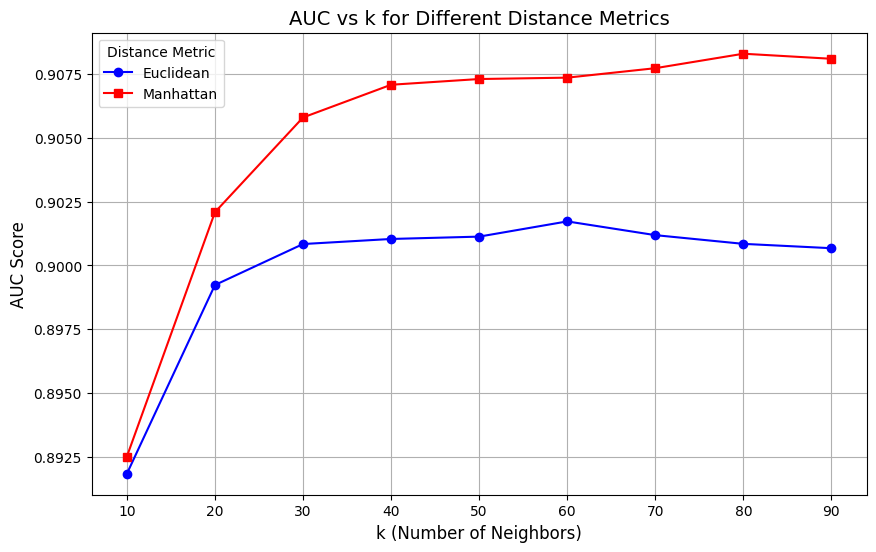

In [50]:
# Hyperparameter tuning for k and distance_metric
best_k = 5
best_metric = 'euclidean'
best_auc = 0

euclidean_aucs = []
manhattan_aucs = []
ek_values_out = []
mk_values_out = []
for k, metric, auc in results:
    if metric == 'euclidean':
        euclidean_aucs.append(auc)
        ek_values_out.append(k)
    elif metric == 'manhattan':
        manhattan_aucs.append(auc)
        mk_values_out.append(k)

    if auc > best_auc:
        best_auc = auc
        best_k = k
        best_metric = metric

print(f"Best k: {best_k}, Best metric: {best_metric}, Best AUC: {best_auc}")


plt.figure(figsize=(10, 6))

ek_values_out = np.asarray(ek_values_out)
mk_values_out = np.asarray(mk_values_out)
euclidean_aucs = np.asarray(euclidean_aucs)
manhattan_aucs = np.asarray(manhattan_aucs)

e_idxs = np.argsort(ek_values_out)
m_idxs = np.argsort(mk_values_out)

ek_values_out = ek_values_out[e_idxs]
mk_values_out = mk_values_out[m_idxs]
euclidean_aucs = euclidean_aucs[e_idxs]
manhattan_aucs = manhattan_aucs[m_idxs]

plt.plot(ek_values_out, euclidean_aucs, marker='o', linestyle='-', color='b', label='Euclidean')
plt.plot(mk_values_out, manhattan_aucs, marker='s', linestyle='-', color='r', label='Manhattan')

plt.title('AUC vs k for Different Distance Metrics', fontsize=14)
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)

plt.legend(title='Distance Metric')

plt.grid(True)
plt.show()

In [51]:
# Train on full dataset with optimal hyperparameters and make predictions on test set
knn = KNN(k=best_k, distance_metric=best_metric)
knn.fit(X, y)
test_predictions = knn.predict(X_test)

# Save test predictions
pd.DataFrame({'id': pd.read_csv('./test.csv')['id'], 'Exited': test_predictions}).to_csv('submissions.csv', index=False)